In [3]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"


import celerite
import emcee
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# Finally set up the plotting to look a little nicer.
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100

In [4]:
def qpp_model(t,A,B,tau_g,P,phase):
    
    F = A*np.exp(-(t-B)**2/(2*tau_g**2))*np.cos(((2*np.pi)/P)*t+phase)
    
    return F

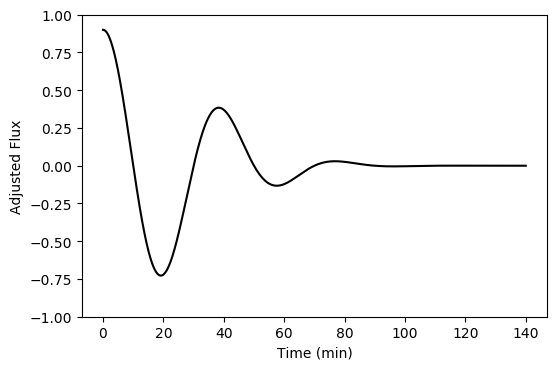

In [9]:
t = np.linspace(0,140,1000)
QPP = qpp_model(t,0.9,0,30,40,0)

plt.plot(t,QPP,'k')
plt.ylim(-1.0,1.0)
plt.xlabel('Time (min)')
plt.ylabel('Adjusted Flux')

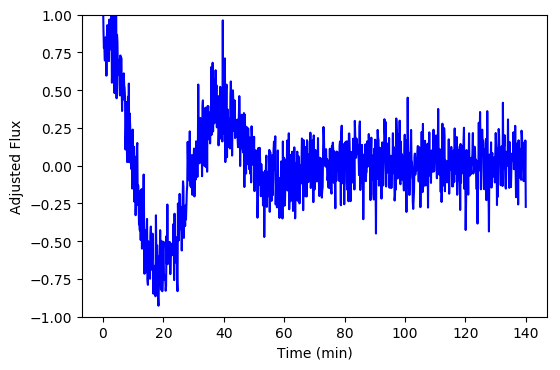

In [8]:
noise = np.random.randn(np.size(t)) * 0.15
model = QPP + noise
plt.plot(t,model,'blue')
plt.ylim(-1.0,1.0)
plt.xlabel('Time (min)')
plt.ylabel('Adjusted Flux')

In [6]:
from celerite import terms

# A non-periodic component
Q = 1.0 / np.sqrt(2.0)
w0 = 3.0
S0 = np.var(model) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

# A periodic component
Q = 1.0
w0 = 3.0
S0 = np.var(QPP+noise) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)


In [8]:
gp = celerite.GP(kernel, mean=np.mean(QPP+noise))
gp.compute(t, noise)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(QPP+noise)))


Initial log likelihood: 294.60030289493693


In [9]:
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
print("parameter_names:\n{0}\n".format(gp.get_parameter_names()))
print("parameter_vector:\n{0}\n".format(gp.get_parameter_vector()))
print("parameter_bounds:\n{0}\n".format(gp.get_parameter_bounds()))

parameter_dict:
OrderedDict([('kernel:terms[0]:log_S0', -3.0095972949181746), ('kernel:terms[0]:log_omega0', 1.0986122886681098), ('kernel:terms[1]:log_S0', -3.3561708851981473), ('kernel:terms[1]:log_Q', 0.0), ('kernel:terms[1]:log_omega0', 1.0986122886681098)])

parameter_names:
('kernel:terms[0]:log_S0', 'kernel:terms[0]:log_omega0', 'kernel:terms[1]:log_S0', 'kernel:terms[1]:log_Q', 'kernel:terms[1]:log_omega0')

parameter_vector:
[-3.00959729  1.09861229 -3.35617089  0.          1.09861229]

parameter_bounds:
[(-15, 15), (-15, 15), (-15, 15), (-15, 15), (-15, 15)]



In [10]:
gp.get_parameter_dict()

OrderedDict([('kernel:terms[0]:log_S0', -3.0095972949181746),
             ('kernel:terms[0]:log_omega0', 1.0986122886681098),
             ('kernel:terms[1]:log_S0', -3.3561708851981473),
             ('kernel:terms[1]:log_Q', 0.0),
             ('kernel:terms[1]:log_omega0', 1.0986122886681098)])

In [18]:
x = np.linspace(0, 140, 5000)
pred_mean, pred_var = gp.predict(QPP+noise, x, return_var=True)
pred_std = np.sqrt(pred_var)

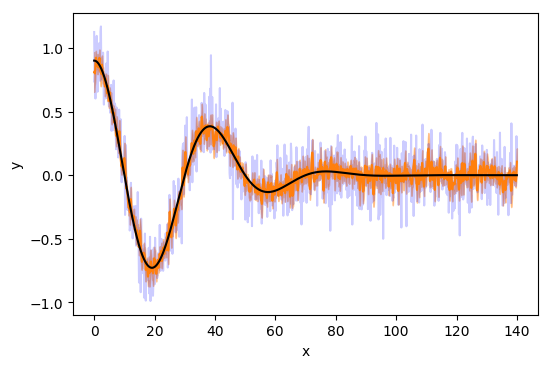

In [29]:
color = "#ff7f0e"
plt.plot(t, QPP+noise,color='blue',alpha=0.2)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.4,
                 edgecolor="none")
plt.plot(t, QPP, "k", lw=1.5, alpha=1)
plt.xlabel("x")
plt.ylabel("y")
